In [8]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2
%reload_ext tensorboard
import os
import torch
import torchvision
import torchvision.transforms.functional as fn
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

from src.data.car_plate_dataset import UFPRDataset, id_to_filepath

In [13]:
os.chdir(r"C:\Users\Arya\PycharmProjects\projectSentry\ProjectSentry\data\raw\UFPR-ALPR dataset\training")
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...

In [3]:
os.chdir(r"C:/Users/Arya/PycharmProjects/projectSentry/ProjectSentry/data/raw/UFPR-ALPR dataset/testing/track0091")
os.getcwd()

'C:\\Users\\Arya\\PycharmProjects\\projectSentry\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset\\testing\\track0091'

In [5]:
# os.chdir(os.listdir(os.getcwd())[0])
im = Image.open("track0091[01].png")
np_im = np.array(im)

gS = torchvision.transforms.Grayscale()
resize = torchvision.transforms.Resize(size=500)
crop = torchvision.transforms.CenterCrop(size=400)


# print(np_im)
# im

(500, 888)


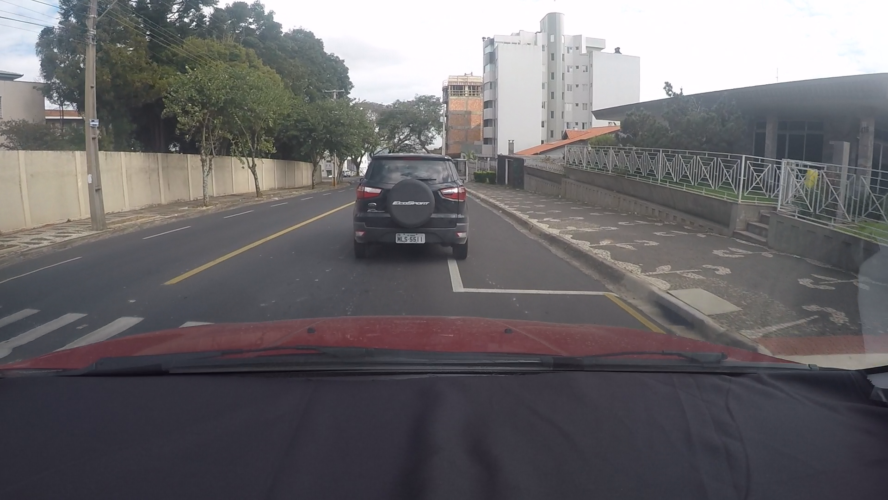

In [6]:
print(np.asarray(gS(resize(im))).shape)
resize(im)
resize(Image.fromarray(np.asarray(im)))

In [7]:
resized_and_grey = resize(grey_im)
cropped = crop(resized_and_grey)
print(cropped.size)
resized_and_grey

NameError: name 'grey_im' is not defined

In [8]:
with open("track0091[01].txt", "r") as track0091_01_txt:
    txt = track0091_01_txt.readlines()

    lp = txt[6].replace("plate: ", "") # line 6 in the txt has licence plate number
    plate = txt[7] # line 7 has bounding box location for licence plate

    plate = ''.join(i for i in plate if i.isdigit() or i == " ")
    temp_list = [int(i) for i in plate.replace(" ", "", 1).split(" ")]
    # plate_date = (x_min, y_min, x_max, y_max)
    plate_data = np.array([temp_list[0], temp_list[1], temp_list[0] + temp_list[2], temp_list[1] + temp_list[3]], dtype=np.int32)

print(list(lp)[:-1])
print(plate_data)

['M', 'L', 'S', '-', '5', '5', '1', '1']
[855 504 919 525]


In [9]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    print(bb)
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    # bb = bb.astype(np.int)
    Y[bb[1]:bb[3]+1, bb[0]:bb[2]+1] = 1
    return Y

In [10]:
def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0:
        return np.zeros(4, dtype=np.float32)
    x_min = np.min(rows)
    y_min = np.min(cols)
    x_max = np.max(rows)
    y_max = np.max(cols)
    return np.array([x_min, y_min, x_max, y_max], dtype=np.int32)

In [100]:
import PIL


def resize_image_bb(image: PIL.Image, bb, sz):
    # write_path,
    """Resize an image and its bounding box and write image to new path"""
    im = np.asarray(image)
    # print(im.shape)
    im_resized = cv2.resize(im, (int((16 / 9) * sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int((16 / 9) * sz), sz))
    # new_path = str(write_path/read_path.parts[-1])
    # cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return im_resized, mask_to_bb(Y_resized)

In [11]:
plt.close()
fig, ax = plt.subplots(ncols=2, nrows=2)

# plt.imshow(cv.cvtColor(cv.imread("track0091[01].png"), cv.COLOR_BGR2RGB))
ax[0, 0].imshow(np.asarray(grey_im), cmap='gray')

rect = patches.Rectangle((855, 504), 64, 21, linewidth=.5, edgecolor='r', facecolor='none')
ax[0, 0].add_patch(rect)
# print(rect.get_corners())


# im = Image.open("track0091[01].png")
ax[0, 1].imshow(create_mask(plate_data, np.asarray(im)), cmap="gray")

resized_im, resized_bb = resize_image_bb(Image.open("track0091[01].png"), plate_data, 500)

ax[1, 0].imshow(resized_im)

x_min, y_min, x_max, y_max = resized_bb
rect = patches.Rectangle((x_min, y_min),x_max-x_min, y_max-y_min, linewidth=.5, edgecolor='r', facecolor='none' )
ax[1, 0].add_patch(rect)

ax[1, 1].imshow(create_mask(resized_bb, resized_im), cmap='gray')

plt.show()

<IPython.core.display.Javascript object>

NameError: name 'grey_im' is not defined

In [165]:
train_dataset = UFPRDataset(
    "C:\\Users\\Arya\\workspace\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset\\training",
    resize=torchvision.transforms.Resize(size=500),
    grayscale=torchvision.transforms.Grayscale()
)

finished setting up data


In [179]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from models.models import LPCNNv1

train_dataloader = DataLoader(train_dataset)
trainer = pl.Trainer(max_epochs=1)
model = LPCNNv1()

trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | conv1        | Conv2d     | 832   
1 | rel1         | ReLU       | 0     
2 | conv2        | Conv2d     | 51.3 K
3 | rel2         | ReLU       | 0     
4 | pool         | MaxPool2d  | 0     
5 | flatten      | Flatten    | 0     
6 | dense        | Linear     | 897 M 
7 | rel3         | ReLU       | 0     
8 | bounding_box | Sequential | 772   
--------------------------------------------
898 M     Trainable params
0         Non-trainable params
898 M     Total params
3,592.109 Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [13]:
# testing glob
id_to_filepath("000101")

'C:\\Users\\Arya\\workspace\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset\\training\\track0001\\track0001[01].png'

In [164]:
train_dataset[1799] # last index means 1800 photos in training

(<PIL.Image.Image image mode=L size=888x500>,
 (['A', 'P', 'B', '-', '4', '3', '2', '7'], array([799, 349, 903, 387])),
 'C:\\Users\\Arya\\workspace\\ProjectSentry\\data\\raw\\UFPR-ALPR dataset\\training\\track0060\\track0060[30].png')